In [3]:
using LatBo
using LatBo.LB

Sets up LB parameters.

In [2]:
δt = 0.0005 # seconds
δx = 0.001 # meters
viscosity = 0.04 # Pascal per second
ρ = 1000. # kg per m³
c_s² = 1. / 3. # lattice units
c_s = √c_s²

mmHg2Pascal = 133.3223874
lattice_mass = ρ * δx^3
lattice_pressure = lattice_mass / (δx * δt^2)

τ = 0.5 + δt * viscosity / ρ / c_s² / δt^2 
ρ₀ = (c_s² + mmHg2Pascal / lattice_pressure * 80.1) / c_s² # 80.1 in mmHg
ρ₁ = (c_s² + mmHg2Pascal / lattice_pressure * 80.0) / c_s² # 80.1 in mmHg
μ₀ = [0.0, 0.0]

Npoints = 90, 30

τ, ρ₀, lattice_mass, lattice_pressure

(0.74,9.009342423055,1.0000000000000002e-6,4000.0000000000005)

Sets up the simulation geometry as well as the LB kernel.

In [3]:
sim = SandBox(:D2Q9, Npoints, ρ₀=ρ₀, μ₀=μ₀)
Playground.initialize(sim.playground) do i, j
    coords = Float64[i, j]
    if j == 1 || j == Npoints[2]
        return Playground.SOLID
    elseif i == 1
        return Playground.INLET
    elseif i == Npoints[1]
        return Playground.OUTLET
    else
        return Playground.FLUID
    end
end

streamers = {
    Playground.INLET => NashZeroOrderPressure{Float64}([0, 1], ρ₀),
    Playground.OUTLET => NashZeroOrderPressure{Float64}([0, 1], ρ₁),
#    Playground.INLET => ConstantVelocityIOlet([0.02, 0]),
#    Playground.OUTLET => ConstantVelocityIOlet([0.02, 0]),
    Playground.FLUID => FluidStreaming(),
    Playground.SOLID => HalfWayBounceBack()
}

sim.kernels = {
    Playground.FLUID => FluidKernel(SingleRelaxationTime{Float64}(1./τ), streamers)
}

Dict{Uint8,LocalKernel} with 1 entry:
  0x02 => FluidKernel(SingleRelaxationTime{Float64}(1.3513513513513513),[0x04=>…

Does actual computation, while keeping trac of total kinetic energy

In [4]:
kinetic = Float64[]
run!(sim, nsteps=600) do
    ν = velocity(sim)
    valid = !isnan(ν)
    push!(kinetic, 0.5sum(momentum(sim)[valid] .* ν[valid]))
end

Plots stuff. Warning: Gadfly is really slow to load the first time around...

Options{:ToggleButtons,Any}([Input{Symbol}] μ,"i",:μ,"μ",["μ"=>:μ,"μx"=>:μx,"μy"=>:μy,"playground"=>:playground,"density"=>:density,"kinetic"=>:kinetic,"f_1"=>:f_1,"f_2"=>:f_2,"f_3"=>:f_3,"f_4"=>:f_4,"f_5"=>:f_5,"f_6"=>:f_6,"f_7"=>:f_7,"f_8"=>:f_8,"f_9"=>:f_9])

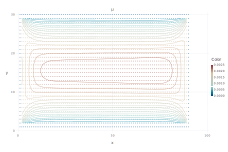

In [5]:
using Interact
using Gadfly
width=9inch
set_default_plot_size(width, 2width * float(Npoints[2])/float(Npoints[1]))

x = [gridcoords(sim.indexing, i)[1] for i = 1:length(sim.playground)]
y = [gridcoords(sim.indexing, i)[2] for i = 1:length(sim.playground)]

only_fluid = filter(i -> sim.playground[i] == Playground.FLUID, collect(1:length(sim.playground)))
fᵢ = {parse("f_$i") => i for i in 1:9} 
k_fᵢ = sort(collect(keys(fᵢ)), by=x->fᵢ[x])

@manipulate for i = vcat([:μ, :μx, :μy, :playground, :density, :kinetic], k_fᵢ)
    title = Guide.title(string(i))
    if i == :playground
        plotthis = sim.playground
    elseif i == :density
        plotthis = (density(sim) .- ρ₁) / (ρ₀ - ρ₁)
    elseif i == :μx
        plotthis = momentum(sim)[1, :]
    elseif i == :μy
        plotthis = momentum(sim)[2, :]
    elseif i == :μ
        plotthis = sqrt(momentum(sim)[1, :].^2 + momentum(sim)[2, :].^2)
    elseif i != :kinetic      
        j = fᵢ[i]
        plotthis = reshape(sim.populations[j, :], Npoints)
        title = Guide.title("population: $(sim.lattice.celerities[:, j])")
    end
    if i == :kinetic
        plot(x=collect(1:length(kinetic)), y=kinetic, Geom.line, Geom.point)
    elseif i == :playground
        plot(x=x[only_fluid], y=y[only_fluid], color=plotthis[only_fluid], title)    
    else
        lines = reshape(plotthis[only_fluid], Npoints[1]-2, Npoints[2]-2)
        # plot(x=x, y=y, color=plotthis, z=lines, Geom.point, Geom.contour, title)
        plot(
            layer(x=x, y=y, color=plotthis, Geom.point),
            layer(
                x=collect(2:(size(lines, 1)+1)), 
                y=collect(2:(size(lines, 2) + 1)),
                z=lines, Geom.contour
            ),
            Theme(default_point_size=1pt, highlight_width=0pt),
            title
        )
    end
end